# **RADI623: Natural Language Processing**

### Assignment: Natural Language Processing
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI605/tree/main)

## **Medical Specialty Identification**

The problem of predicting one’s illnesses wrongly through self-diagnosis in medicine is very real. In a report by the [Telegraph](https://www.telegraph.co.uk/news/health/news/11760658/One-in-four-self-diagnose-on-the-internet-instead-of-visiting-the-doctor.html), nearly one in four self-diagnose instead of visiting the doctor. Out of those who misdiagnose, nearly half have misdiagnosed their illness wrongly [reported](https://bigthink.com/health/self-diagnosis/). While there could be multiple root causes to this problem, this could stem from a general unwillingness and inability to seek professional help.

Elevent percent of the respondents surveyed, for example, could not find an appointment in time. This means that crucial time is lost during the screening phase of a medical treatment, and early diagnosis which could have resulted in illnesses treated earlier was not achieved.

With the knowledge of which medical specialty area to focus on, a patient can receive targeted help much faster through consulting specialist doctors. To alleviate waiting times and predict which area of medical specialty to focus on, we can utilize natural language processing (NLP) to solve this task.

Given any medical transcript or patient condition, this solution would predict the medical specialty that the patient should seek help in. Ideally, given a sufficiently comprehensive transcript (and dataset), one would be able to predict exactly which illness he is suffering from.

In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt 
import spacy
import re
import warnings 
warnings.filterwarnings('ignore')

from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoTokenizer

import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

nlp = spacy.load('en_core_web_sm')

### <code>Question 1</code>: Conduct an exploratory data analysis on the dataset.  Report the corpus statistics with appropriate visualization.  Explain clearly why the selected visualization fits your purpose.  

In [5]:
data = pd.read_csv('../data/mtsamples.csv')

num_samples = len(data)
num_medical_specialties = data['medical_specialty'].nunique()

def calculate_univariate(data):
    description_lengths   = data['description'].str.len()
    transcription_lengths = data['transcription'].str.len()

    avg_description_length = description_lengths.mean()
    min_description_length = description_lengths.min()
    max_description_length = description_lengths.max()

    avg_transcription_length = transcription_lengths.mean()
    min_transcription_length = transcription_lengths.min()
    max_transcription_length = transcription_lengths.max()

    dictionary = {}
    dictionary['description']   = [avg_description_length, min_description_length, max_description_length]
    dictionary['transcription'] = [avg_transcription_length, min_transcription_length, max_transcription_length]
    return dictionary

summary = calculate_univariate(data)

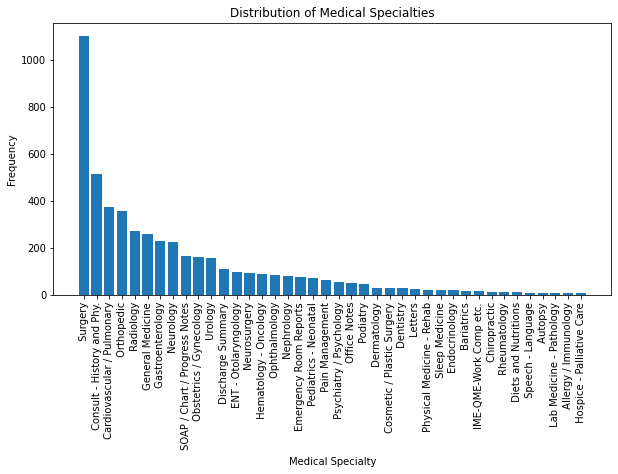

In [6]:
specialty_counts = data['medical_specialty'].value_counts()

plt.figure(figsize = (10, 5))
plt.bar(specialty_counts.index, specialty_counts.values)
plt.xlabel('Medical Specialty')
plt.ylabel('Frequency')
plt.title('Distribution of Medical Specialties')
plt.xticks(rotation = 90)
plt.show()

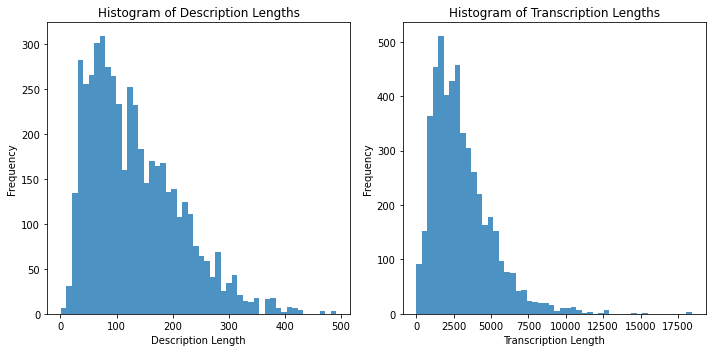

In [4]:
description_lengths   = data['description'].str.len()
transcription_lengths = data['transcription'].str.len()

fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].hist(description_lengths, bins = 50, alpha = 0.8)
axs[0].set_xlabel('Description Length')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Description Lengths')

axs[1].hist(transcription_lengths, bins = 50, alpha = 0.8)
axs[1].set_xlabel('Transcription Length')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Transcription Lengths')

plt.tight_layout()
plt.show()

## Datasets, Preprocessing, and Streaming

By default, loading local files creates a DatasetDict object with a train split. We can see this by inspecting the dataset object. This shows us the number of rows and the column names associated with the training set. To enable dataset streaming you just need to pass the <code>streaming = True</code> argument to the <code>load_dataset()</code> function. The streaming mode will ensure that our local device won't have to load the whole dataset at once.

In [163]:
dataset = load_dataset('csv', data_files = '../data/mtsamples.csv', delimiter = '\t')
dataset_sample = dataset['train'].shuffle(seed = 42).select(range(1000))
dataset_sample[:3]

Found cached dataset csv (C:/Users/Renan/.cache/huggingface/datasets/csv/default-3d692acf3d985cae/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\Renan\.cache\huggingface\datasets\csv\default-3d692acf3d985cae\0.0.0\6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317\cache-1f4c04c12388c32d.arrow


{'description,medical_specialty,sample_name,transcription,keywords': [' Medical management, status post left total knee arthroplasty., Orthopedic, Orthopedic Consult ,"REASON FOR CONSULT: , Medical management, status post left total knee arthroplasty.,PAST MEDICAL HISTORY:,1.  Polyarthritis.,2.  Acromegaly.,3.  Hypothyroidism.,4.  Borderline hypertension.,5.  Obesity.,PAST SURGICAL HISTORY: , Hernia repair, resection of tumor, right thumb arthrodesis, carpal tunnel decompression, bilateral hip replacement, right total knee replacement about 2 months ago, open reduction of left elbow fracture.,REVIEW OF SYSTEMS:,CONSTITUTIONAL SYMPTOMS:  No fever or recent general malaise.,ENT:  Not remarkable.,RESPIRATORY:  No cough or shortness of breath.,CARDIOVASCULAR:  The patient denies any heart problems.  No orthopnea.  No palpitations.  No syncopal episodes.,GASTROINTESTINAL:  No nausea.  No vomiting.  No history of GI bleed.,GENITOURINARY:  No dysuria, no hematuria.,ENDOCRINE:  The patient is 

We have loaded our local dataset. But while this worked for the training set, what we really want is to include both the train and test splits in a single DatasetDict object so we can apply Dataset.map() functions across both splits at once. To do this, we can provide a dictionary to the data_files argument that maps each split name to a file associated with that split:

In [188]:
data = pd.read_csv('../data/mtsamples.csv')
shuffle = data.sample(frac = 1, random_state = 42)

train_data,  test_data = train_test_split(shuffle,    test_size = 0.30, random_state = 42)
train_data, valid_data = train_test_split(train_data, test_size = 0.15, random_state = 42) 

train_data.to_csv('../data/train.csv', index = False)
valid_data.to_csv('../data/valid.csv', index = False)
test_data. to_csv('../data/test.csv' , index = False)

data_files = {
    'train': '../data/train.csv',
    'valid': '../data/valid.csv',
    'test' : '../data/test.csv'}

dataset = load_dataset('csv', data_files = data_files, delimiter = '\t', streaming = True)
dataset

{'train': <datasets.iterable_dataset.IterableDataset at 0x27db1e15820>,
 'valid': <datasets.iterable_dataset.IterableDataset at 0x27db1e15c70>,
 'test': <datasets.iterable_dataset.IterableDataset at 0x27db1e15370>}

As usual, our texts need to be converted to token IDs before the model can make sense of them. Big difference in the case of token classification tasks is that we have pre-tokenized inputs. Fortunately, the tokenizer API can deal with that pretty easily; we just need to warn the tokenizer with a special flag.

To begin, let’s create our tokenizer object. As we said before, we will be using a BERT pretrained model, so we’ll start by downloading and caching the associated tokenizer:

In [192]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_dataset = dataset.map(lambda x: tokenizer(x['transciption']))
shuffled_dataset = dataset.shuffle(buffer_size = 10_000, seed = 42)
next(iter(shuffled_dataset['train']))

{'description,medical_specialty,sample_name,transcription,keywords': ' Care conference with family at the bedside and decision to change posture of care from aggressive full code status to terminal wean with comfort care measures in a patient with code last night with CPR and advanced cardiac life support., Hospice - Palliative Care, Care Conference With Family ,"REASON FOR FOLLOWUP:,  Care conference with family at the bedside and decision to change posture of care from aggressive full code status to terminal wean with comfort care measures in a patient with code last night with CPR and advanced cardiac life support.,HISTORY OF PRESENT ILLNESS: , This is a 65-year-old patient originally admitted by me several weeks ago with profound hyponatremia and mental status changes.  Her history is also significant for likely recurrent aspiration pneumonia and intubation earlier on this admission as well.  Previously while treating this patient I had met with the family and discussed how aggress

In [190]:
dataset_head = dataset['train'].take(2)
list(dataset_head)

[{'description,medical_specialty,sample_name,transcription,keywords': ' Left Cardiac Catheterization, Left Ventriculography, Coronary Angiography and Stent Placement., Surgery, Cardiac Cath & Coronary Angiography ,"PROCEDURE:,  Left Cardiac Catheterization, Left Ventriculography, Coronary Angiography and Stent Placement.,INDICATIONS: , Atherosclerotic coronary artery disease.,PATIENT HISTORY: , This is a 55-year-old male.  He presented with 3 hours of unstable angina.,PAST CARDIAC HISTORY: , History of previous arteriosclerotic cardiovascular disease.  Previous ST elevation MI.,REVIEW OF SYSTEMS.,  The creatinine value is 1.3 mg/dL mg/dL.,PROCEDURE MEDICATIONS:,1.  Visipaque 361 mL total dose.,2.  Clopidogrel bisulphate (Plavix) 225 mg PO,3.  Promethazine (Phenergan) 12.5 mg total dose.,4.  Abciximab (Reopro) 10 mg IV bolus,5.  Abciximab (Reopro) 0.125 mcg/kg/minute, 4.5 mL/250 mL D5W x 17 mL,6.  Nitroglycerin 300 mcg IC total dose.,DESCRIPTION OF PROCEDURE:,APPROACH: , Left heart cath

The <code>preprocessing</code> function takes a sentence, removes hyperlinks, performs various token-level filters (removing stop words, symbols, punctuation marks, and whitespace), lemmatizes the remaining tokens to their base forms, and returns the cleaned sentence as a string. Specifically, the code <code>token.pos_ != 'SYM' and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE'</code> checks if the token's part-of-speech (POS) tag is not 'SYM' (symbol), 'PUNCT' (punctuation), or 'SPACE'. It further filters out tokens that are symbols, punctuation marks, or represent whitespace. We also appended the lowercase lemma (base form) of the token, obtained using <code>token.lemma_</code>, to the cleaned_tokens list.

In [193]:
def remove_hyperlinks(sentence):
    sentence = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"', " ", sentence)
    return sentence

def preprocessing(sentence):
    sentence = remove_hyperlinks(sentence)
    doc = nlp(sentence)
    cleaned_tokens = []
    for token in doc:
        if token.is_stop == False and \
            token.pos_ != 'SYM' and \
            token.pos_ != 'PUNCT' and token.pos_ != 'SPACE':
            cleaned_tokens.append(token.lemma_.lower().strip())
    return ' '.join(cleaned_tokens)

def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['tokens'], 
        truncation = True, 
        is_split_into_words = True)
    all_labels = examples['ner_tags']
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs['labels'] = new_labels
    return tokenized_inputs

def to_tokens(sentence = 'I loved reading deep learning literature in the \
              Clinical Epidemiology and Biostatistics office!'):
    inputs = tokenizer(sentence)
    return tokenizer.convert_ids_to_tokens(inputs.input_ids)

df = pd.read_csv('../data/mtsamples.csv')
for i, row in df.iterrows():
    clean_descript = preprocessing(row['description'])
    df.at[i,'description'] = clean_descript

In [198]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_ids = []
attention_masks = []

for description in df['description']:
    encoded_dict = tokenizer.encode_plus(
        description,
        add_special_tokens = True,
        max_length = 512,
        padding = 'max_length',
        truncation = True,
        return_attention_mask=True,
        return_tensors = 'pt'
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)

### Uses BERT without fine tuning on the LSTM with 50 neurons for the baseline model.  Other hyperparameters are not controlled.   

In [162]:
class BaselineModel(nn.Module):
    def __init__(self, num_classes, hidden_size = 50):
        super(BaselineModel, self).__init__()
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm = nn.LSTM(input_size  = self.bert.config.hidden_size,
                            hidden_size = hidden_size,
                            batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        pooled_output = outputs.pooler_output
        lstm_output, _ = self.lstm(pooled_output)
        logits = self.fc(lstm_output[:, -1, :])  
        return logits
    
num_classes = 47
hidden_size = 50

bert_model = BertModel.from_pretrained('bert-base-uncased')
model = BaselineModel(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bi

### Propose the better model with supporting assumptions why your proposed model should be better than the baseline model.  Clearly explanations are required in which aspect that you would like to improve from the baseline model

In [187]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx = 50)
        self.lstm = nn.LSTM(emb_dim, 
                           hid_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)        
        return self.fc(hn)